# Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [12]:
import requests
from urllib.parse import urlencode

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, normaltest
from scipy.stats import chi2_contingency
import pingouin as pg

sns.set(rc={"figure.figsize": (8, 6)})

In [13]:
def down_df(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    
    return download_url

In [14]:
public_key_1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
group_test = pd.read_csv(down_df(public_key_1), sep=';')

public_key_2 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
group_add = pd.read_csv(down_df(public_key_2), sep=',')

public_key_3 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
user_active = pd.read_csv(down_df(public_key_3), sep=';')

public_key_4 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
checks = pd.read_csv(down_df(public_key_4), sep=';')


# Проведем предварительный анализ данных

Посмотрим на структуру данных

In [15]:
group_test.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [16]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [17]:
user_active.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [18]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Посмотрим тип данных и наличие пропущенных значений

In [19]:
group_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [20]:
group_add.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [21]:
user_active.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [22]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Проверим наличие дубликатов

In [23]:
group_test.duplicated().any()

False

In [24]:
group_add.duplicated().any()


False

In [25]:
user_active.duplicated().any()


False

In [26]:
checks.duplicated().any()

False

Посмотрим статистическую информацию по покупкам пользователей

In [27]:
checks.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


Объединим два датафрейма с данными пользователей и групп, к которым они относятся

In [28]:
groups = pd.concat([group_test, group_add], axis=0, ignore_index=True)

Проверим на дубликаты

In [29]:
groups.duplicated().any()

False

Создадим датафрейм с активными пользователями которые заходили в дни эксперемента  и совершили оплату с разбивкой на группы

In [30]:
# Добавим информацию о сумме совершоннной покупки и доп столбец purchase
users_group = user_active.merge(groups, left_on='student_id', right_on='id', how='left')
users_group_checks = users_group.merge(checks, on='student_id', how='left')
users_group_checks['purchase'] = users_group_checks['rev'].notna().astype(int)
users_group_checks['rev'] = users_group_checks['rev'].fillna(0)
users_group_checks.head()

,student_id,id,grp,rev,purchase
0,581585,581585,A,0.0,0
1,5723133,5723133,A,0.0,0
2,3276743,3276743,B,0.0,0
3,4238589,4238589,A,0.0,0
4,4475369,4475369,B,0.0,0


Посмотрим на количество активных пользователе, которые совершили оплату

In [31]:
users_group_checks.query('rev > 0').groupby('grp', as_index=False).agg({'id' : 'count'})

,grp,id
0,A,78
1,B,314


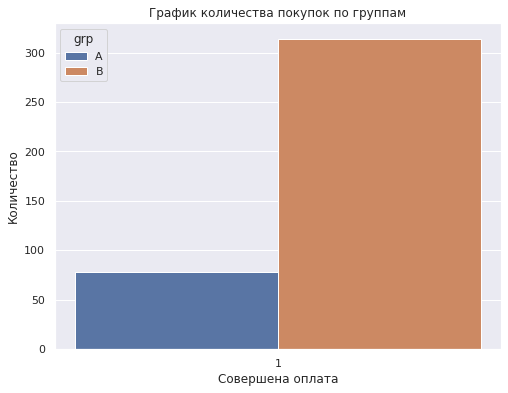

In [32]:
sns.countplot(x = 'purchase', data=users_group_checks.query('rev > 0'), hue='grp')
plt.title('График количества покупок по группам')
plt.xlabel('Совершена оплата')
plt.ylabel('Количество')
plt.show()

Посмотрим, есть ли оплаты у неактивных пользователей

In [33]:
checks.merge(user_active, how='outer', indicator=True)[checks.merge(user_active, how='outer', indicator=True)['_merge'] == 'left_only']

,student_id,rev,_merge
1,3185,690.0,left_only
2,25973,690.0,left_only
3,26280,690.0,left_only
5,100645,630.0,left_only
6,102534,580.0,left_only
...,...,...,...
508,5291900,199.0,left_only
512,5331842,290.0,left_only
521,5486319,199.0,left_only
530,5562806,398.0,left_only


Видим, что есть неактивные пользователи, которые совершили покупку. Есть несколько предположений.

1) Техническая проблема: в файле с активными пользователями отсутствует часть записей.
    
2) На платформе существует подписка на оплату. 

Второй вариант на мой взгляд более вероятен, будем считать его основным.

И так как неактивные пользователи учавствовали в а/б тесте, то мы их учитывать не будем.

Также давайте посмотрим, есть ли пользователи, которые совершили больше одной покупки

In [34]:
users_group_checks.query('purchase == 1').groupby('id').size()

id
1627       1
100300     1
108270     1
264473     1
274352     1
          ..
5645737    1
5651566    1
5662322    1
5681918    1
5740903    1
Length: 392, dtype: int64

Все пользователи совершили не больше одной покупки. Если бы мы знали о сроках эксперимента, то могли бы сделать какие-то выводы, а так просто отметим, что отсутствие повторных покупок говорит нам об отсутствии фейк-транзакций(назовем транзакцию фейковой, если оплата по ней бы не прошла, но транзакция попала бы в наши данные)

Теперь посмотрим на распределение покупок в зависимости от суммы

In [35]:
distribution_control = users_group_checks.query('purchase == 1 and grp == "A"') \
    .groupby('rev', as_index=False) \
    .agg({'id' : 'count'}) \
    .sort_values('id', ascending=False) \
    .rename(columns={'id' : 'count'}) \
    .head(10)
distribution_control

,rev,count
1,290.0,25
4,580.0,6
0,199.0,5
9,990.0,5
5,590.0,5
6,690.0,4
14,1530.0,3
22,3660.0,3
7,840.0,3
3,489.0,2


In [36]:
distribution_test = users_group_checks.query('purchase == 1 and grp == "B"') \
    .groupby('rev', as_index=False) \
    .agg({'id' : 'count'}) \
    .sort_values('id', ascending=False) \
    .rename(columns={'id' : 'count'}) \
    .head(10)
distribution_test

,rev,count
20,1900.0000,93
1,290.0000,45
21,1900.0001,35
0,199.0000,27
9,840.0000,21
12,990.0000,17
7,690.0000,13
14,1140.0000,9
2,398.0000,6
5,590.0000,6


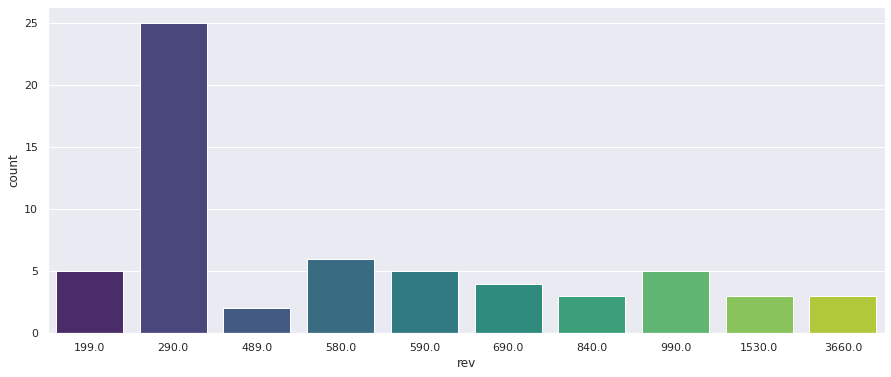

In [37]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.barplot(x='rev', y='count', data=distribution_control, palette='viridis')

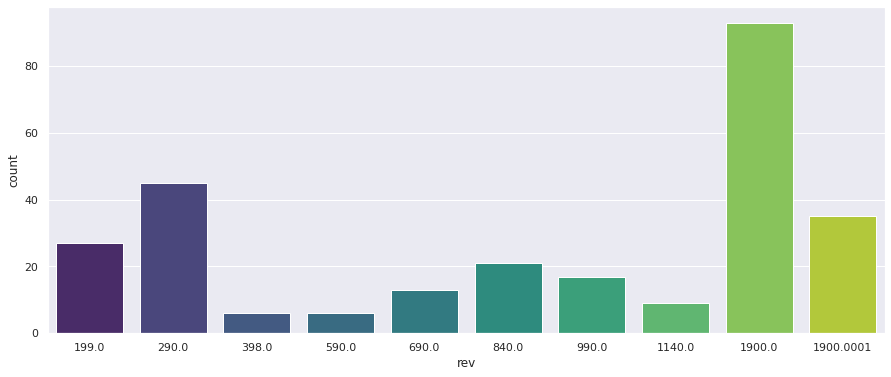

In [38]:
sns.set(rc={"figure.figsize": (15, 6)})

sns.barplot(x='rev', y='count', data=distribution_test, palette='viridis')


Можно наблюдать появление в тестовой группе большого количество платежей на сумму 1900 и 1900.0001. Воозможно произошла какая-то ошибка, не исключено, что запущен новый курс. Утчем это

Посмотрим средний чек в группах

In [39]:
users_group_checks.query('purchase == 1').groupby('grp', as_index=False).agg({'rev' : 'mean'}).round(2)

,grp,rev
0,A,933.59
1,B,1257.88


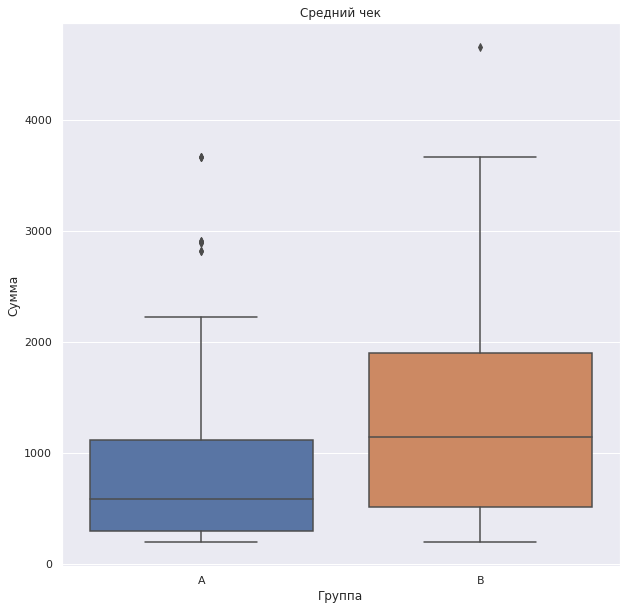

In [40]:
sns.set(rc={"figure.figsize": (10, 10)})

df=users_group_checks.query('purchase == 1')

ax = sns.boxplot(x='grp', y='rev', data=df, whis=1.5)

plt.title('Средний чек')
plt.xlabel('Группа')
plt.ylabel('Сумма')
plt.show()

тело обоев графиков не растянуто, что говорит о том, что разьрос в данных небольшой

Приступим к анализу проведенного теста.

Ввиду ограниченности данных мы не можем посмотреть crush rate, LTV, посмотреть удовлетворенность продуктом(одним из признаков которого могли бы быть повторные покупкии), но мы понимаем, что одной из главных бизнес метрик является прибыль, для расчета которой испобьзуют средний чек. Поэтому в анализе будем смотреть такие метрики как:
1. Средний чек(ARPU)
2. Средний чек на клиента(платящего пользователя)(ARPAU)
3. Конверсию(CR)

# Гипотеза 1: Новая механика оплаты услуг на сайте увеличила средний чек

ARPU = Доход / количество пользователей

In [41]:
users_group_checks.rev.sum() / users_group_checks.id.count()

56.083683431243266

In [42]:
df_arpu = users_group_checks.groupby('grp', as_index=False).agg({'rev' : 'mean'}).round(2)
df_arpu['change'] = df_arpu['rev'].pct_change().mul(100).round(2)

In [43]:
df_arpu

,grp,rev,change
0,A,47.35,NaN
1,B,58.06,22.62


Видим, что средний чек увеличился на 22.62 процента, проверим являются ли эти различия стат значимыми.

Создадим 2 выборки

In [44]:
control = users_group_checks.query('grp == "A"')['rev']
test = users_group_checks.query('grp == "B"')['rev']

Проверим нормальность распределения

H0: Распределение статистически неразличимо от нормального 

H1: Распределение статистически различимо от нормального

In [45]:
stats.normaltest(control)

NormaltestResult(statistic=2240.5957974074026, pvalue=0.0)

In [46]:
stats.normaltest(test)

NormaltestResult(statistic=7797.399211581946, pvalue=0.0)

Распределения в обоих группах отличаются о нормального, но выбоки данных большие, поэтому можем принебречь и используем t-test

H0: Новая механика оплаты услуг на сайте не повлияла на средний чек

H1: Новая механика оплаты услуг на сайте увеличила на средний чек

In [47]:
stats.ttest_ind(control, test)

Ttest_indResult(statistic=-1.225341107379344, pvalue=0.22048133326988403)

С учетом высокого p-значения, можем сделать вывод, что нет статистически значимых различий между группами, поэтому мы не можем отвергнуть нулевую гипотезу.

# Гипотеза 2: Новая механика оплаты услуг на сайте увеличила средний чек на активного платящего пользователя

In [48]:
df_arpau = users_group_checks.query('purchase == 1')
df_arpau.head()

,student_id,id,grp,rev,purchase
62,1184303,1184303,A,1530.0000,1
67,3354191,3354191,B,1900.0001,1
77,3278734,3278734,B,1900.0000,1
99,720651,720651,A,1980.0000,1
193,1232221,1232221,B,1900.0000,1


In [49]:
table_arpau = df_arpau.groupby('grp', as_index=False).agg({'rev' : 'mean'}).round(2)
table_arpau['change'] = table_arpau['rev'].pct_change().mul(100).round(2)
table_arpau

,grp,rev,change
0,A,933.59,NaN
1,B,1257.88,34.74


In [50]:
df_arpau.groupby('grp').agg({'rev' : 'count'})

,rev
grp,
A,78
B,314


In [51]:
control_arpu = df_arpau.query('grp == "A"')['rev']
test_arpu = df_arpau.query('grp == "B"')['rev']

Проверим нормальность распределения

H0: Распределение статистически неразличимо от нормального 

H1: Распределение статистически различимо от нормального

In [52]:
stats.normaltest(control_arpu)

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

In [53]:
stats.normaltest(test_arpu)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

Распределения в обоих группах отличаются о нормального и выбоки данных не большие, поэтому используем бутстрап.

H0: ARPAU двух выборок равны.

H1:  ARPAU двух выборок различны.

In [54]:
btstrp_control_arpu = stats.bootstrap((control_arpu, ), np.mean, n_resamples=20000)
btstrp_test_arpu = stats.bootstrap((test_arpu, ), np.mean, n_resamples=20000)

print(f'Интервал для контрольной выборки {btstrp_control_arpu.confidence_interval}', f'Интервал для тестовой выборки {btstrp_test_arpu.confidence_interval}', sep = '\n')
print(f'Стандартная ошибка для контрольной выборки {btstrp_control_arpu.standard_error}', f'Стандартная ошибка для тестовой выборки {btstrp_test_arpu.standard_error}', sep ='\n')

Интервал для контрольной выборки ConfidenceInterval(low=758.007906430058, high=1169.0)
Интервал для тестовой выборки ConfidenceInterval(low=1173.7127479544656, high=1348.1174842365026)
Стандартная ошибка для контрольной выборки 103.40021288363027
Стандартная ошибка для тестовой выборки 44.40528214090603


Интервалы средних не пересекаются, можно сделать вывод,  что arpau двух групп стат различаются, поэтому отклоняем нулевую гипотезу

# Гипотеза 3: Новая механика оплаты услуг на сайте увеличила конверсию

In [55]:
users_group_checks

,student_id,id,grp,rev,purchase
0,581585,581585,A,0.0,0
1,5723133,5723133,A,0.0,0
2,3276743,3276743,B,0.0,0
3,4238589,4238589,A,0.0,0
4,4475369,4475369,B,0.0,0
...,...,...,...,...,...
8336,1794344,1794344,B,0.0,0
8337,296883,296883,B,0.0,0
8338,3598448,3598448,B,0.0,0
8339,3610547,3610547,B,290.0,1


Посчитаем CR и построим график

In [56]:
table_cr = users_group_checks.groupby('grp', as_index=False).size().rename(columns={'size' : 'users'})
table_cr['purchase_success'] = users_group_checks.query('purchase == 1').groupby('grp', as_index=False).size()['size']
table_cr['cr'] = np.round(table_cr.purchase_success / table_cr.users * 100, 2)
table_cr

,grp,users,purchase_success,cr
0,A,1538,78,5.07
1,B,6803,314,4.62


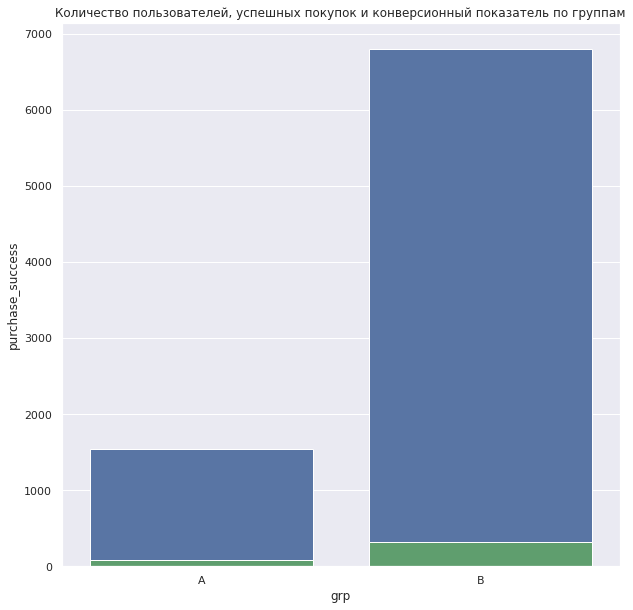

In [57]:
barplot = sns.barplot(x='grp', y='users', data=table_cr, color='b', label='Количество пользователей')
barplot = sns.barplot(x='grp', y='purchase_success', data=table_cr, color='g', label='Успешные покупки')

plt.title('Количество пользователей, успешных покупок и конверсионный показатель по группам')
plt.show()

Можно заметить небольшое различие в конверсии, проверим является ли оно стат значимым. Так как сравниваем категориальные переменные, будем испльзовать хи-квадрат

H0: Конверсия в тестовой и контрольной группе стаистически значимо не отличается

H1: Конверсия в тестовой и контрольной группе стаистически значимо отличается


Создаем таблицу сопряженности

In [58]:
contingency_table = table_cr[['users', 'purchase_success']].values


In [59]:
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Хи-квадрат: {chi2}")
print(f"p-значение: {p}")

Хи-квадрат: 0.43612258061018483
p-значение: 0.5089998823014525


С учетом высокого p-значения, можно сделать вывод, что нет статистически значимых различий между группами на уровне значимости 0.05. Не можем опровергнуть нулевую гипотезу.

# Выводы:

Для анализа итогов эксперимента мы брали метрики: ARPU, ARPAU и CR.
На мой взгляд CR - главная метрика, которая должна была измениться при успешном эксперименте, но в резкльтате тестов мы не увидели стат значимыв различий и CR и ARPU. Несмотря на то, что имеются стат значимые отличия в ARPAU, я считаю, что запыскатьь новую механику оплыты не стоит.

# Задание 2

### Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [60]:
import pandas as pd
import requests
from io import StringIO

In [61]:
def down_df(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    
    return download_url

def metrics_get(url):
    # Если при считывании получим ошибку, получим ответ
    response = requests.get(url)
    
    if response.status_code == 200:
        # Считываем все в pandas датафрейм
        public_key_1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
        public_key_2 = url
        public_key_3 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
        public_key_4 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

        group_test = pd.read_csv(down_df(public_key_1), sep=';')
        group_add = pd.read_csv(down_df(public_key_2), sep=',')
        user_active = pd.read_csv(down_df(public_key_3), sep=';')
        checks = pd.read_csv(down_df(public_key_4), sep=';')
    
        # Добавим датафрейм с доп участниками к основному
        # Если столбцы будут отличаться изменим их на названия столбцов дф group_test
        
        if not group_test.columns.equals(group_add.columns):
            group_add.columns = group_test.columns
            groups = pd.concat([group_test, group_add], axis=0, ignore_index=True)
        else:    
            groups = pd.concat([group_test, group_add], axis=0, ignore_index=True)
        
        # Добавим информацию о сумме совершоннной покупки и доп столбец purchase с информацией совершена покупка или нет
        users_group = user_active.merge(groups, left_on='student_id', right_on='id', how='left')
        users_group_checks = users_group.merge(checks, on='student_id', how='left')
        users_group_checks['purchase'] = users_group_checks['rev'].notna().astype(int)
        users_group_checks['rev'] = users_group_checks['rev'].fillna(0)
        
        # Считаем метрики
        df_arpu = users_group_checks.groupby('grp', as_index=False).agg({'rev' : 'mean'}).round(2)
        df_arpau = users_group_checks.query('purchase == 1')
        def_arpau = df_arpau.groupby('grp', as_index=False).agg({'rev' : 'mean'}).round(2)
        def_cr = users_group_checks.groupby('grp', as_index=False).size().rename(columns={'size' : 'users'})
        def_cr['purchase_success'] = users_group_checks.query('purchase == 1').groupby('grp', as_index=False).size()['size']
        def_cr['cr'] = np.round(def_cr.purchase_success / def_cr.users * 100, 2)
        def_cr = def_cr[['grp', 'cr']]
        
        # Создаем итоговый дф
        mitrics_df = pd.merge(df_arpu, def_arpau, on='grp').merge(def_cr, on='grp')
        mitrics_df = mitrics_df.rename(columns={
            'rev_x' : 'arpu',
            'rev_y' : 'arpau'})
        
        return mitrics_df

        
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None


In [62]:
metrics_df = metrics_get('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
metrics_df

,grp,arpu,arpau,cr
0,A,47.35,933.59,5.07
1,B,58.06,1257.88,4.62


In [63]:
def plot_metrics(df):
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

    # График для 'rev_x'
    df.plot(kind='bar', x='grp', y='arpu', color=['blue', 'green'], ax=axes[0], legend=False)
    axes[0].set_title('ARPU')
    axes[0].set_ylabel('Сумма')

    # График для 'rev_y'
    df.plot(kind='bar', x='grp', y='arpau', color=['blue', 'green'], ax=axes[1], legend=False)
    axes[1].set_title('ARPAU')
    axes[1].set_ylabel('Сумма')

    # График для 'cr'
    df.plot(kind='bar', x='grp', y='cr', color=['blue', 'green'], ax=axes[2], legend=False)
    axes[2].set_title('Conversion Rate')
    axes[2].set_ylabel('%')

    # Устанавливаем общий заголовок
    plt.suptitle('Метрики контрольной и тестовой  группы', fontsize=16)

    # Показываем графики
    plt.show()



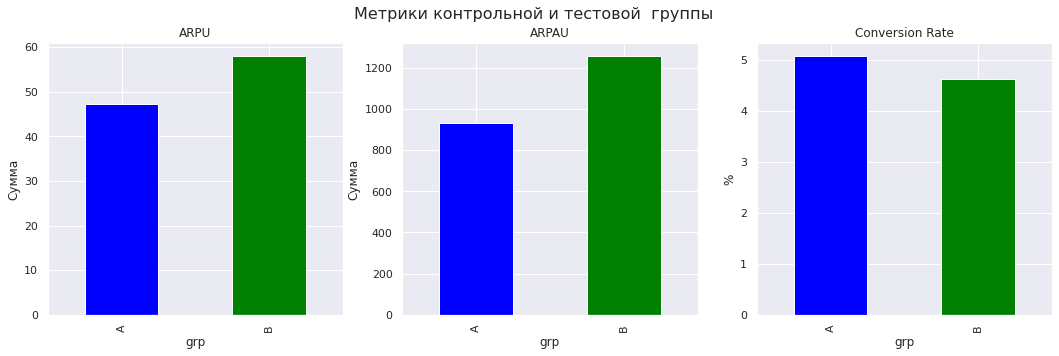

In [64]:
plot_metrics(metrics_df)
